In [2]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

#for text pre-processing
import re, string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer

nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('stopwords')

#for model-building
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score

# bag of words
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

#for word embedding
import gensim
from gensim.models import Word2Vec #Word2Vec is mostly used for huge datasets

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\tboug\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\tboug\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\tboug\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\tboug\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
txt_file = 'Details.txt'

In [4]:
with open(txt_file, encoding = 'utf-8') as f:
    txt=f.read()
txt=txt.split(';;;')

In [5]:
txt=np.reshape(txt,(int(len(txt)/2),2))
df_txt=pd.DataFrame(txt,columns=['Text','Class'])
df_txt.head()

,Text,Class
0,- Nom et adresse officiels de l'organisme ache...,Assurance
1,\n- Nom et adresse officiels de l'organisme ac...,Management
2,\n- Nom et adresse officiels de l'organisme ac...,Restauration
3,\n- Nom et adresse officiels de l'organisme ac...,Construction
4,\n- Nom et adresse officiels de l'organisme ac...,Assurance


Assurance       2
Construction    1
Management      1
Restauration    1
Name: Class, dtype: int64


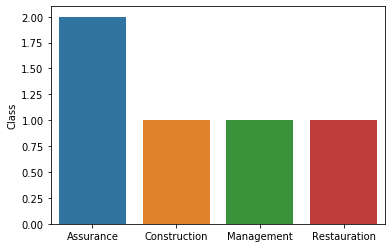

In [6]:
# CLASS DISTRIBUTION
#if dataset is balanced or not
x=df_txt.Class.value_counts()
print(x)
sns.barplot(x.index,x)

In [7]:
#Missing values
df_txt.isna().sum()

Text     0
Class    0
dtype: int64

In [8]:
#1. WORD-COUNT
df_txt['word_count'] = df_txt['Text'].apply(lambda x: len(str(x).split()))
for i in df_txt.Class.value_counts().index:
    print(df_txt[df_txt.Class==i]['word_count'].mean()) #Disaster tweets
    print(df_txt[df_txt.Class!=i]['word_count'].mean()) #Non-Disaster tweets
#Disaster tweets are more wordy than the non-disaster tweets

#2. CHARACTER-COUNT
df_txt['char_count'] = df_txt['Text'].apply(lambda x: len(str(x)))
for i in df_txt.Class.value_counts().index:
    print(df_txt[df_txt.Class==i]['char_count'].mean()) #Disaster tweets
    print(df_txt[df_txt.Class!=i]['char_count'].mean()) #Non-Disaster tweets
#Disaster tweets are longer than the non-disaster tweets

#3. UNIQUE WORD-COUNT
df_txt['unique_word_count'] = df_txt['Text'].apply(lambda x: len(set(str(x).split())))
for i in df_txt.Class.value_counts().index:
    print(df_txt[df_txt.Class==i]['unique_word_count'].mean()) #Disaster tweets
    print(df_txt[df_txt.Class!=i]['unique_word_count'].mean()) #Non-Disaster tweets

648.5
1057.6666666666667
924.0
886.5
602.0
967.0
1647.0
705.75
4533.0
7227.666666666667
6278.0
6117.75
4345.0
6601.0
11060.0
4922.25
346.0
467.3333333333333
442.0
413.0
234.0
465.0
726.0
342.0


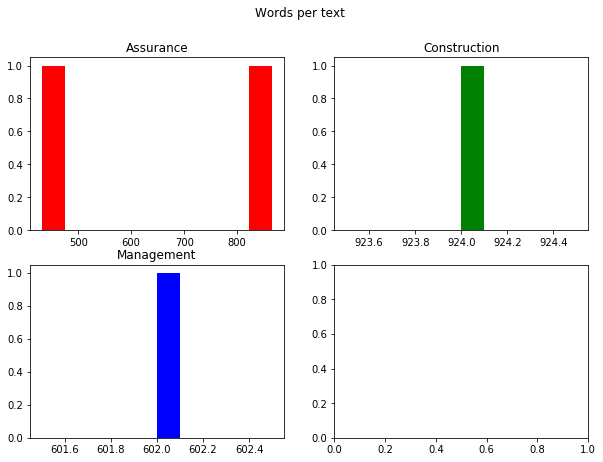

In [9]:
#Plotting word-count per tweet
fig,ax=plt.subplots(2,2,figsize=(10,7))

train_words=df_txt[df_txt['Class']==df_txt.Class.value_counts().index[0]]['word_count']
ax[0,0].hist(train_words,color='red')
ax[0,0].set_title(df_txt.Class.value_counts().index[0])

train_words=df_txt[df_txt['Class']==df_txt.Class.value_counts().index[1]]['word_count']
ax[0,1].hist(train_words,color='green')
ax[0,1].set_title(df_txt.Class.value_counts().index[1])

train_words=df_txt[df_txt['Class']==df_txt.Class.value_counts().index[2]]['word_count']
ax[1,0].hist(train_words,color='blue')
ax[1,0].set_title(df_txt.Class.value_counts().index[2])

#train_words=df_txt[df_txt['Class']==df_txt.Class.value_counts().index[3]]['word_count']
#ax[1,1].hist(train_words,color='green')
#ax[1,1].set_title(df_txt.Class.value_counts().index[3])

fig.suptitle('Words per text')
plt.show()

In [10]:
#1. Common text preprocessing
text = "   This is a message to be cleaned. It may involve some things like: <br>, ?, :, ''  adjacent spaces and tabs     .  "

#convert to lowercase and remove punctuations and characters and then strip
def preprocess(text):
    text = text.lower() #lowercase text
    text=text.strip()  #get rid of leading/trailing whitespace 
    text=re.compile('<.*?>').sub('', text) #Remove HTML tags/markups
    text = re.compile('[%s]' % re.escape(string.punctuation)).sub(' ', text)  #Replace punctuation with space. Careful since punctuation can sometime be useful
    text = re.sub('\s+', ' ', text)  #Remove extra space and tabs
    text = re.sub(r'\[[0-9]*\]',' ',text) #[0-9] matches any digit (0 to 10000...)
    text=re.sub(r'[^\w\s]', '', str(text).lower().strip())
    text = re.sub(r'\d',' ',text) #matches any digit from 0 to 100000..., \D matches non-digits
    text = re.sub(r'\s+',' ',text) #\s matches any whitespace, \s+ matches multiple whitespace, \S matches non-whitespace 
    
    return text

text=preprocess(text)
print(text)  #text is a string

this is a message to be cleaned it may involve some things like adjacent spaces and tabs


In [11]:
#3. LEXICON-BASED TEXT PROCESSING EXAMPLES
 
#1. STOPWORD REMOVAL
def stopword(string):
    a= [i for i in string.split() if i not in stopwords.words('english')]
    return ' '.join(a)

text=stopword(text)
print(text)

#2. STEMMING
 
# Initialize the stemmer
snow = SnowballStemmer('english')
def stemming(string):
    a=[snow.stem(i) for i in word_tokenize(string) ]
    return " ".join(a)
text=stemming(text)
print(text)

#3. LEMMATIZATION
# Initialize the lemmatizer
wl = WordNetLemmatizer()
 
# This is a helper function to map NTLK position tags
# Full list is available here: https://www.ling.upenn.edu/courses/Fall_2003/ling001/penn_treebank_pos.html
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

# Tokenize the sentence
def lemmatizer(string):
    word_pos_tags = nltk.pos_tag(word_tokenize(string)) # Get position tags
    a=[wl.lemmatize(tag[0], get_wordnet_pos(tag[1])) for idx, tag in enumerate(word_pos_tags)] # Map the position tag and lemmatize the word/token
    return " ".join(a)

text = lemmatizer(text)
print(text)

message cleaned may involve things like adjacent spaces tabs
messag clean may involv thing like adjac space tab
messag clean may involv thing like adjac space tab


In [12]:
#FINAL PREPROCESSING
def finalpreprocess(string):
    return lemmatizer(stopword(preprocess(string)))

df_txt['clean_text'] = df_txt['Text'].apply(lambda x: finalpreprocess(x))
df_txt=df_txt.drop(columns=['word_count','char_count','unique_word_count'])
df_txt.head()

,Text,Class,clean_text
0,- Nom et adresse officiels de l'organisme ache...,Assurance,nom et adresse officiels de l organisme achete...
1,\n- Nom et adresse officiels de l'organisme ac...,Management,nom et adresse officiels de l organisme achete...
2,\n- Nom et adresse officiels de l'organisme ac...,Restauration,nom et adresse officiels de l organisme achete...
3,\n- Nom et adresse officiels de l'organisme ac...,Construction,nom et adresse officiels de l organisme achete...
4,\n- Nom et adresse officiels de l'organisme ac...,Assurance,nom et adresse officiels de l organisme achete...


In [13]:
# create Word2vec model
#here words_f should be a list containing words from each document. say 1st row of the list is words from the 1st document/sentence
#length of words_f is number of documents/sentences in your dataset
df_txt['clean_text_tok']=[nltk.word_tokenize(i) for i in df_txt['clean_text']] #convert preprocessed sentence to tokenized sentence
model = Word2Vec(df_txt['clean_text_tok'],min_count=1)  #min_count=1 means word should be present at least across all documents,
#if min_count=2 means if the word is present less than 2 times across all the documents then we shouldn't consider it


w2v = dict(zip(model.wv.index2word, model.wv.syn0))  #combination of word and its vector

#for converting sentence to vectors/numbers from word vectors result by Word2Vec
class MeanEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        # if a text is empty we should return a vector of zeros
        # with the same dimensionality as all the other vectors
        self.dim = len(next(iter(word2vec.values())))

    def fit(self, X, y):
        return self

    def transform(self, X):
        return np.array([
            np.mean([self.word2vec[w] for w in words if w in self.word2vec]
                    or [np.zeros(self.dim)], axis=0)
            for words in X
        ])

D:\Python\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.vectors instead).
  if __name__ == '__main__':


In [14]:
#SPLITTING THE TRAINING DATASET INTO TRAINING AND VALIDATION
 
# Input: "reviewText", "rating" and "time"
# Target: "log_votes"
X_train, X_val, y_train, y_val = train_test_split(df_txt["clean_text"],
                                                  df_txt["Class"],
                                                  test_size=0.33,
                                                  random_state = 711047,
                                                  shuffle=True)
X_train_tok= [nltk.word_tokenize(i) for i in X_train]  #for word2vec
X_val_tok= [nltk.word_tokenize(i) for i in X_val]      #for word2vec

#TF-IDF
# Convert x_train to vector since model can only run on numbers and not words- Fit and transform
tfidf_vectorizer = TfidfVectorizer(use_idf=True)
X_train_vectors_tfidf = tfidf_vectorizer.fit_transform(X_train) #tfidf runs on non-tokenized sentences unlike word2vec
# Only transform x_test (not fit and transform)
X_val_vectors_tfidf = tfidf_vectorizer.transform(X_val) #Don't fit() your TfidfVectorizer to your test data: it will 
#change the word-indexes & weights to match test data. Rather, fit on the training data, then use the same train-data-
#fit model on the test data, to reflect the fact you're analyzing the test data only based on what was learned without 
#it, and the have compatible


#Word2vec
# Fit and transform
modelw = MeanEmbeddingVectorizer(w2v)
X_train_vectors_w2v = modelw.transform(X_train_tok)
X_val_vectors_w2v = modelw.transform(X_val_tok)

In [15]:
#FITTING THE CLASSIFICATION MODEL using Logistic Regression(tf-idf)

lr_tfidf=LogisticRegression(solver = 'liblinear', C=10, penalty = 'l2')
lr_tfidf.fit(X_train_vectors_tfidf, y_train)  #model

#Predict y value for test dataset
y_predict = lr_tfidf.predict(X_val_vectors_tfidf)
y_prob = lr_tfidf.predict_proba(X_val_vectors_tfidf)[:,1]
 

print(classification_report(y_val,y_predict))
print('Confusion Matrix:',confusion_matrix(y_val, y_predict))

              precision    recall  f1-score   support

   Assurance       1.00      1.00      1.00         1
  Management       0.00      0.00      0.00         0
Restauration       0.00      0.00      0.00         1

    accuracy                           0.50         2
   macro avg       0.33      0.33      0.33         2
weighted avg       0.50      0.50      0.50         2

Confusion Matrix: [[1 0 0]
 [0 0 0]
 [0 1 0]]


D:\Python\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
D:\Python\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
D:\Python\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
